# Learning Spatial Relationships with MISTy

Here, we show how to use LIANA's implementation of [MISTy](https://github.com/saezlab/mistyR), a framework presented in [Tanevski et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02663-5).

MISTy is a tool that helps us better understand how different features, such as genes or cell types, interact with each other in space. MISTy does so by learning both **intra-** and **extracellular** relationships - i.e. those that occur within and between cells/spots. A major advantage of MISTy is its flexibility. It can model different perspectives, or "views," each describing a different way markers are related to each other. Each of these views can describe a different spatial context, i.e. define a relationship among the observed expressions of the markers, such as intracellular regulation or paracrine regulation.

MISTy has only one fixed view - i.e. the intraview, which contains the target (dependent) variables. The other views we refer to as extra views, and they contain the independent variables used to predict the intra view. MISTy can fit any number of extra views, and each extra view can contain any number of variables. The extra views can thus simultaneously learn the dependencies of target variables across different modalities, such as cell type proportions, pathways, or genes, etc.

MISTy represents each view represents as a potential source of variation in the measurements of the target  variables in the intra view. MISTy further analyzes each view to determine how it contributes to the overall expression or abundance of each target variable. It explains this contribution by identifying the interactions between measurements that led to the observed results.


<img src="misty.png" width=1000 />

To showcase MISTy, we use a single 10x Visium slide from [Kuppe et al. (2022)](https://www.nature.com/articles/s41586-022-05060-x).

## Environment

```{bash}
pip install squidpy
pip install "decoupler>=1.4.0"

```

In [1]:
import scanpy as sc
import squidpy as sq
import decoupler as dc
import plotnine as p9

In [2]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData

## Load and Normalize Data

We will use an ischemic 10X Visium spatial slide from [Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x). It is a tissue sample obtained from a patient with myocardial infarction, specifically focusing on the ischemic zone of the heart tissue. 

The slide provides spatially-resolved information about the cellular composition and gene expression patterns within the tissue.

In [3]:
adata = sc.read("kuppe_heart19.h5ad", backup_url='https://figshare.com/ndownloader/files/41501073?private_link=4744950f8768d5c8f68c')

In [4]:
adata.obs.head()

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac,celltype_niche,molecular_niche
AAACAAGTATCTCCCA-1,1,50,102,Visium_19_CK297,3125,8.047510,7194.0,8.881142,24.770642,31.387267,39.797053,54.503753,0.085630,ctniche_1,molniche_9
AAACAATCTACTAGCA-1,1,3,43,Visium_19_CK297,3656,8.204398,10674.0,9.275660,35.956530,42.167885,49.456624,61.045531,0.033275,ctniche_5,molniche_3
AAACACCAATAACTGC-1,1,59,19,Visium_19_CK297,3013,8.011023,7339.0,8.901094,33.247036,39.910069,47.227143,59.326884,0.029139,ctniche_5,molniche_3
AAACAGAGCGACTCCT-1,1,14,94,Visium_19_CK297,4774,8.471149,14235.0,9.563529,22.739726,29.884089,37.850369,51.099403,0.149194,ctniche_7,molniche_2
AAACAGCTTTCAGAAG-1,1,43,9,Visium_19_CK297,2734,7.913887,6920.0,8.842316,35.664740,42.268786,50.000000,62.384393,0.025601,ctniche_5,molniche_3


Normalize data

In [5]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Spot clusters

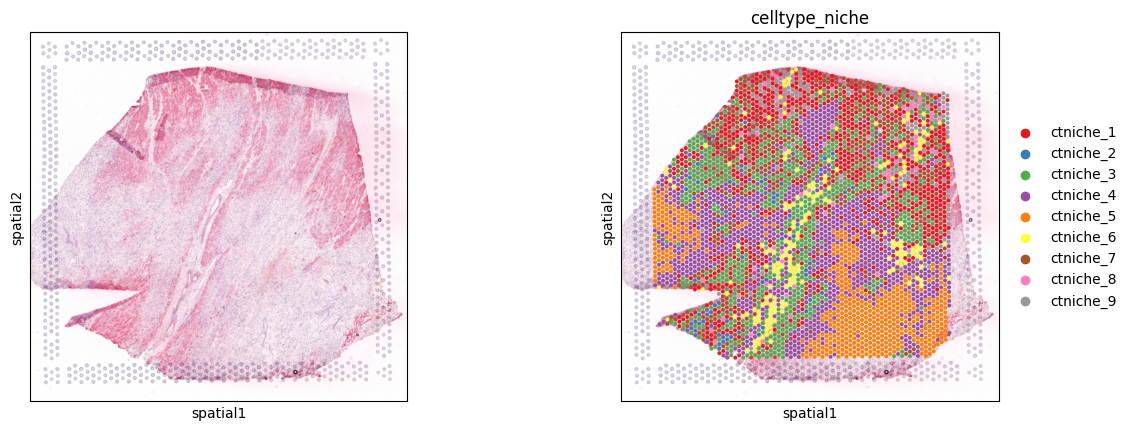

In [6]:
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche'], size=1.3, palette='Set1')

##### Extract Cell type Composition
This slide comes with estimated cell type proportions using cell2location; See [Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x). Let's extract from .obsm them to an independent AnnData object.

In [7]:
# Rename to more informative names
full_names = {'Adipo': 'Adipocytes',
              'CM': 'Cardiomyocytes',
              'Endo': 'Endothelial',
              'Fib': 'Fibroblasts',
              'PC': 'Pericytes',
              'prolif': 'Proliferating',
              'vSMCs': 'Vascular_SMCs',
              }
# but only for the ones that are in the data
adata.obsm['compositions'].columns = [full_names.get(c, c) for c in adata.obsm['compositions'].columns]

In [8]:
comps = li.ut.obsm_to_adata(adata, 'compositions')

In [9]:
comps.var

""
Adipocytes
Cardiomyocytes
Endothelial
Fibroblasts
Lymphoid
Mast
Myeloid
Neuronal
Pericytes
Proliferating


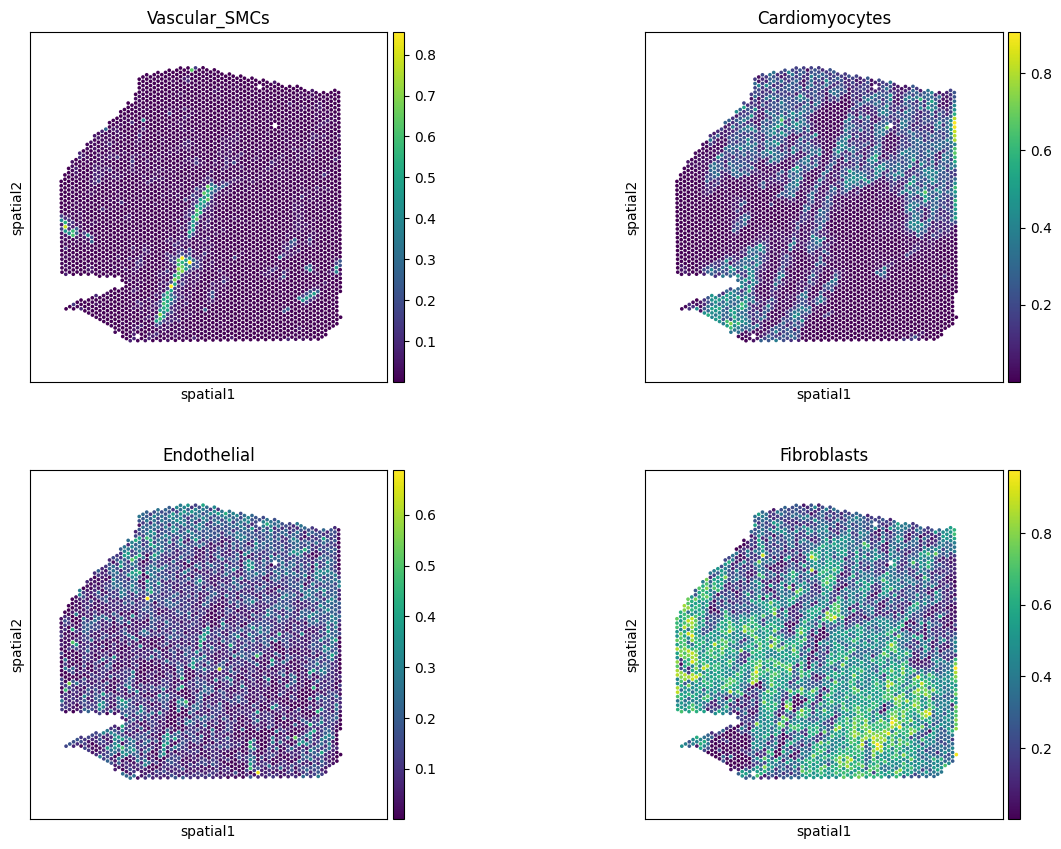

In [10]:
# check key cell types
sq.pl.spatial_scatter(comps,
                      color=['Vascular_SMCs','Cardiomyocytes',
                             'Endothelial', 'Fibroblasts'],
                      size=1.3, ncols=2, img_alpha=0
                      )

## Funcomics

Before we run MISTy, let's estimate pathway activities as a way to make the data a bit more interpretable.
We will use [decoupler-py](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613) with pathways genesets from [PROGENy](https://www.nature.com/articles/s41467-017-02391-6). See [this tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/spatial.html) for details.

In [11]:
# obtain genesets
progeny = dc.get_progeny(organism='human', top=500)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [12]:
# use multivariate linear model to estimate activity
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

Running mlm on mat with 4113 samples and 17703 targets for 14 sources.


100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


In [13]:
# extract progeny activities as an AnnData object
acts_progeny = li.ut.obsm_to_adata(adata, 'mlm_estimate')

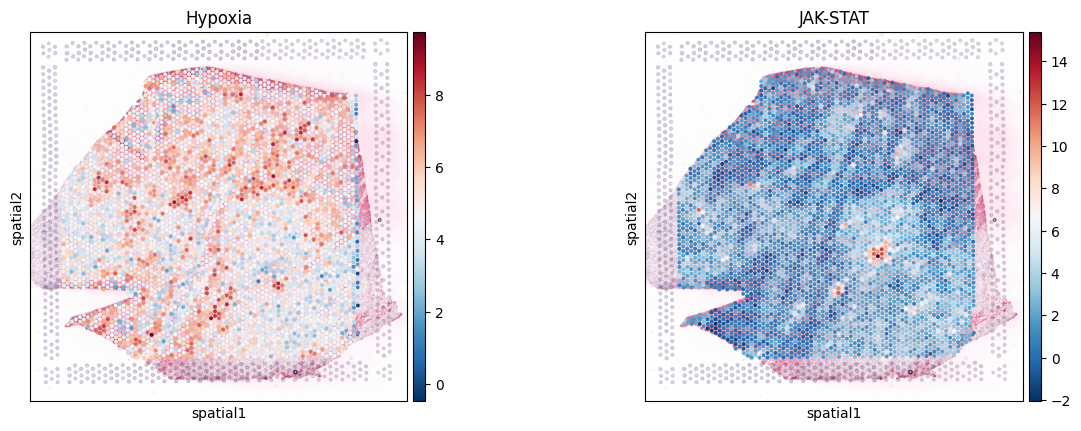

In [14]:
# Check how the pathway activities look like
sq.pl.spatial_scatter(acts_progeny, color=['Hypoxia', 'JAK-STAT'], cmap='RdBu_r', size=1.3)

### Formatting & Running MISTy

The implementation of MISTy in LIANA relies on [MuData](https://github.com/scverse/mudata) objects [(Bredikhin et al., 2022)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02577-8) and extends them to a very simple child class we call "MistyData". 
To make it easier to use, we provide functions to construct "MistyData" objects that transform the data into a format that MISTy can use.

Briefly, a "MistyData" object is just a MuData object with **intra** as one of the modalities - this is the view in which the (**target**) variables explained by all other views are stored. 
MISTy is flexible to any other view that is appended, provided it also contains a spatial neighbors graph.

<div class="alert alert-info">
  Writing a MistyData object will simply result in a MuData object being written to disk.
  To read it back as MistyData, use `mudata.read_h5ad` and pass back it to the `MistyData()` function.
</div>

Let's use `genericMistyData` to construct a MuData object with the intra view and the cell type proportions as the first view.
Then it additionally build a 'juxta' view for the spots that are neighbors of each other, and a 'para' view for all surrounding spots within a certain radius, or bandwidth.

In this case, we will use cell type compositions per spot as the intra view, and we will use the PROGENy pathway activities as the juxta and para views:

In [15]:
misty = genericMistyData(intra=comps, extra=acts_progeny, cutoff=0.05, bandwidth=200, coord_type='generic', n_rings=1)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [16]:
misty

MuData object with n_obs × n_vars = 4113 × 39
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  3 modalities
    intra:	4113 x 11
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      obsm:	'spatial'
    juxta:	4113 x 14
      obsm:	'spatial'
      obsp:	'spatial_connectivities'
    para:	4113 x 14
      obsm:	'spatial'
      obsp:	'spatial_connectivities'

## Learn Relationships with MISTy

Now that we have constructed the object, let's learn the relationships across the views.

In [17]:
misty(verbose = True)

Now learning: Vascular_SMCs: 100%|██████████| 11/11 [01:03<00:00,  5.74s/it]


MISTy returns two DataFrames:
* `target_metrics` - the metrics that describe the target variables from the intra view, including R-squared across different views as well as the estimated contributions to the predictive performance of each view per target.
* `interactions` - feature importances per view

if `inplace` is true (Default), these are appended to the MuData object.

Let's check the variance explained when predicting each target variables in the intra view, with other variables (predictors) in the intra view itself. We can see that it explains itself relatively well (as expected).

In [18]:
misty.uns['target_metrics'].head()

,target,intra_R2,multi_R2,gain_R2,intra,juxta,para
0,Adipocytes,0.215315,0.279058,0.063743,0.502847,0.243877,0.253277
1,Cardiomyocytes,0.877470,0.892319,0.014850,0.780453,0.037678,0.181869
2,Endothelial,0.740765,0.740782,0.000018,0.955763,0.007449,0.036788
3,Fibroblasts,0.935028,0.935156,0.000128,0.966020,0.000000,0.033980
4,Lymphoid,0.108310,0.139884,0.031574,0.541284,0.142692,0.316024


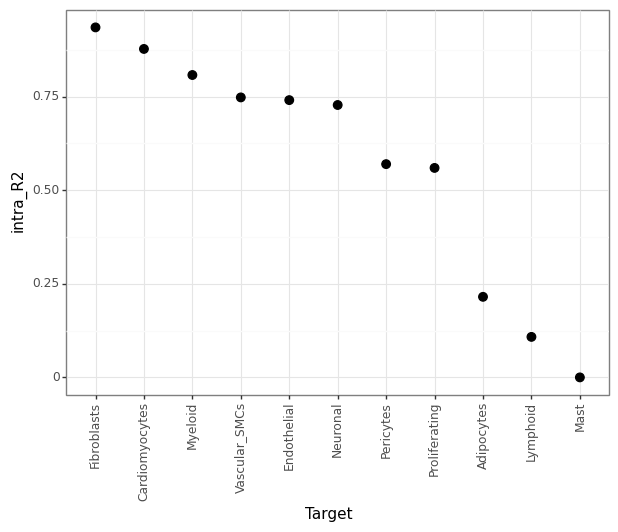

<ggplot: (8741319897569)>

In [19]:
li.pl.target_metrics(misty, stat='intra_R2', return_fig=True)

MISTy additionally calculate `gain_R2`, or in other words the performance gain when we additionally consider the other views (in addition to intra). When we look at the variance explained by the other views, we see that they explain a bit less (as expected), but still there is still some gain of predictive performance:

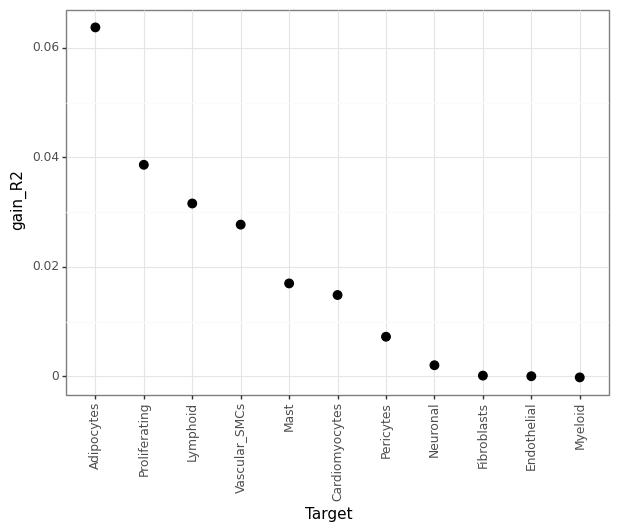

<ggplot: (8741319679928)>

In [20]:
li.pl.target_metrics(misty, stat='gain_R2')

We can also check the contribution to the predictive performance of each view per target:

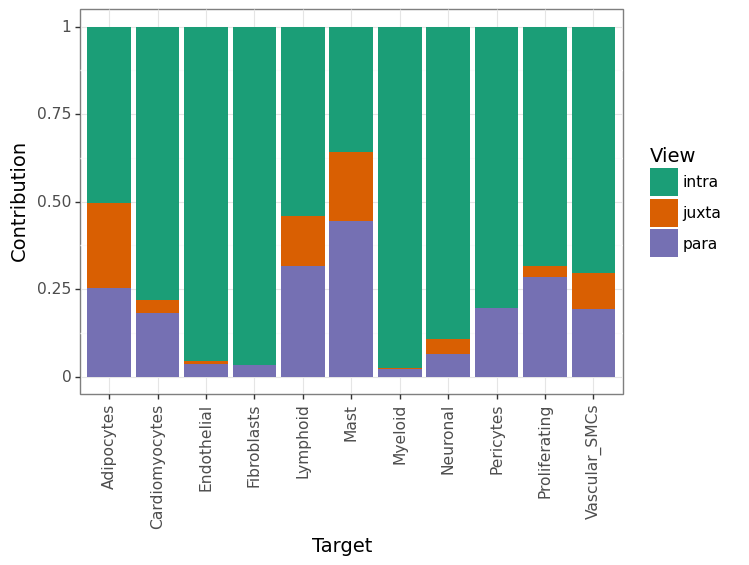

<ggplot: (8741342025407)>

In [21]:
li.pl.contributions(misty, return_fig=True)

Finally, using the information above we know which variables are best explained by our model, and we know which view explains them best. 
So, we can now also see what are the specific variables that explain each target best:

In [22]:
# this information is stored here:
misty.uns['interactions'].head()

,target,predictor,view,importances
0,Adipocytes,Cardiomyocytes,intra,0.063997
1,Adipocytes,Endothelial,intra,0.077043
2,Adipocytes,Fibroblasts,intra,0.054170
3,Adipocytes,Lymphoid,intra,0.048505
4,Adipocytes,Mast,intra,0.131783


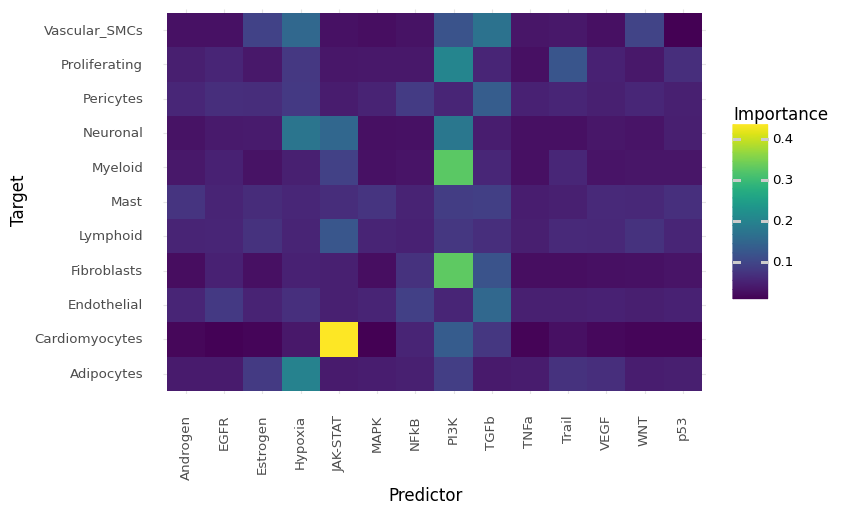

<ggplot: (8741319559967)>

In [23]:
li.pl.interactions(misty, view='juxta', return_fig=True)

### Linear Misty

By default, MISTy uses a Random Forest to learn the relationships within the views.
However, we can also use a Linear model, which is much faster and more interpretable.

Moreover, we will **bypass** predicting the intraview with features within the intraview features (`bypass_intra`).
This will allow us to see how well the other views explain the intraview, excluding the intraview itself.

In [24]:
misty(verbose = True, model='linear', k_cv=10, seed=1337, bypass_intra=True)

Now learning: Vascular_SMCs: 100%|██████████| 11/11 [00:05<00:00,  2.12it/s]


Let's check the joined R-squared for views:

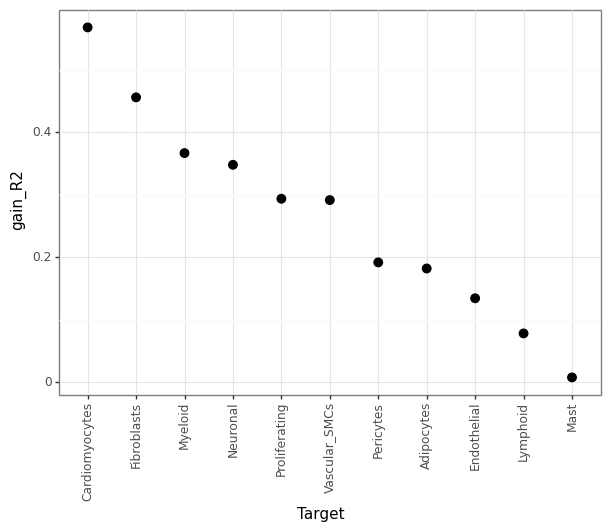

<ggplot: (8741319644446)>

In [25]:
li.pl.target_metrics(misty, stat='gain_R2', return_fig=True)

and their contributions per target:

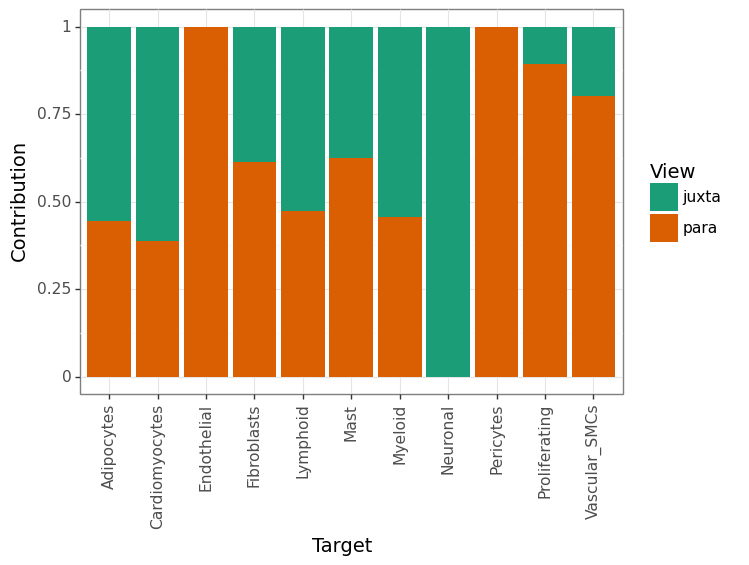

<ggplot: (8741319631263)>

In [26]:
li.pl.contributions(misty, return_fig=True)

Since this is a linear model, the coefficients would not be directly comparable (as are importances in a Random Forest). Thus, we use the coefficients' t-values, as calculated by Ordinary Least Squares, which are signed and directly comparable.

Let's explore the t-values for each target-prediction interaction:

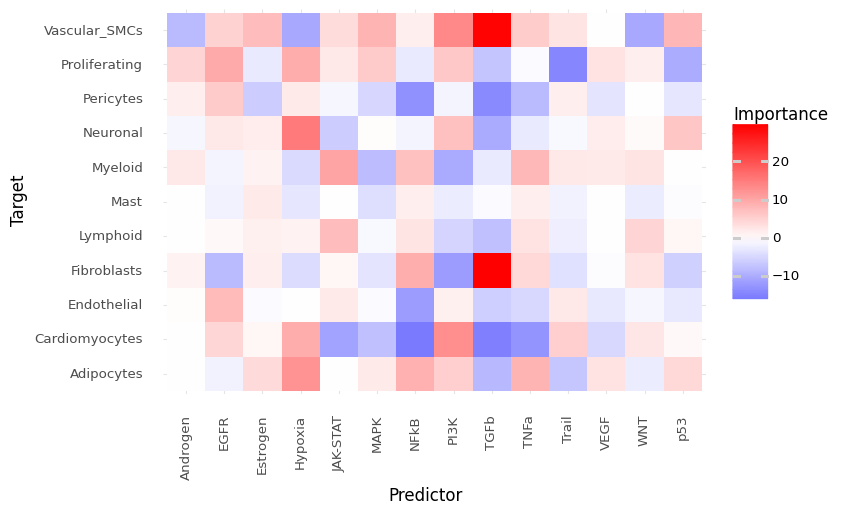

<ggplot: (8741319637200)>

In [27]:
(
    li.pl.interactions(misty, view='juxta', return_fig=True) + 
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)
)

<div class="alert alert-info">
    
<h4> Feature importances </h4>

Regardless of the model, each target is predicted independently, and the interpretation of feature importances depends on the model used. 
By default, we use a random forest, so the feature importances are the mean decrease in Gini impurity of the features. On the other hand, when we use a linear model, the feature importances are the t-values of the model coefficients.


</div>  

## Build Custom Misty Views

As we previously mentioned, one can build any view structure that they deem relevant for their data.
So, let's explore how to build custom views.
Here, we will just use two distinct prior knowledge sources to check which one achieves better predictive performance.

So, let's also estimate Transcription Factor activities with decoupler:

In [28]:
# get TF prior knowledge
net = dc.get_collectri()

In [29]:
# Estimate activities
dc.run_ulm(
    mat=adata,
    net=net,
    verbose=True,
    use_raw=False,
)

Running ulm on mat with 4113 samples and 17703 targets for 694 sources.


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


In [30]:
# extract activities
acts_tfs= li.ut.obsm_to_adata(adata, 'ulm_estimate')

In addition to the features, we also need to provide spatial weights for the spots.
Here, we will use LIANA's inbuilt radial kernel function to compute spatial weights based on the spatial coordinates of the spots.
However, this can be replaced by any other spatial weights matrix, such as those calculated via `squidpy.gr.spatial_neighbors`.

In [31]:
# Calculate spatial neighbors
li.ut.spatial_neighbors(acts_tfs, cutoff=0.1, bandwidth=200, set_diag=False)

Visualize the weights for a specific spot:

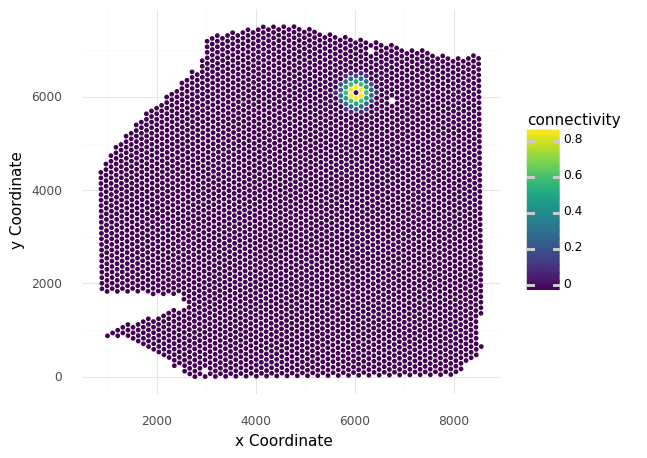

<ggplot: (8741341837874)>

In [32]:
li.pl.connectivity(acts_tfs, idx=0)

In [33]:
# transfer spatial information to progeny activities
# NOTE: spatial connectivities can differ between views, but in this case we will use the same
acts_progeny.obsm['spatial'] = acts_tfs.obsm['spatial']
acts_progeny.obsp['spatial_connectivities'] = acts_tfs.obsp['spatial_connectivities']

Build an object with custom views:

In [34]:
misty = MistyData(data={"intra": comps, "TFs": acts_tfs, "Pathways": acts_progeny})

view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view Pathways is not a csr_matrix. Converting to csr_matrix


In [35]:
misty

MuData object with n_obs × n_vars = 4113 × 719
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  3 modalities
    intra:	4113 x 11
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'log1p', 'celltype_niche_colors'
      obsm:	'compositions', 'mt', 'spatial'
    TFs:	4113 x 694
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'log1p', 'celltype_niche_colors'
      obsm:	'compositions', 'mt', 'spatial', 'mlm_estimate', 'mlm_pvals', 'ulm_estimate', 'ulm_pvals'
      obsp:	'spatial_connectivities'
    Pathways:	4113 x 14
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'log1p', 'celltype_niche_colors'
      obsm:	'compositions', 'mt', 'spatial', 'mlm_estimate', 'mlm_pvals'
      obsp:	'spatial_connectivities'

Run Misty as before:

In [36]:
misty(model='linear', verbose=True, bypass_intra=True)

Now learning: Vascular_SMCs: 100%|██████████| 11/11 [02:00<00:00, 10.95s/it]


We can see that Cardiomyocytes and Fibroblasts are relatively well explained by TFs & Pathways.

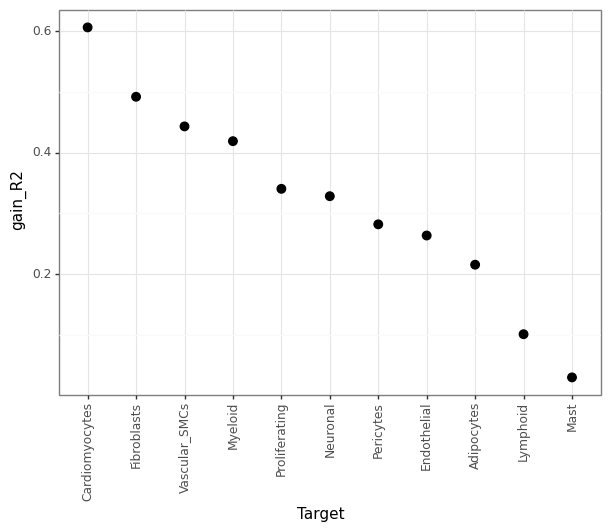

<ggplot: (8741342212036)>

In [37]:
li.pl.target_metrics(misty, stat='gain_R2')

We also see that the two views explain the targets similarly well.

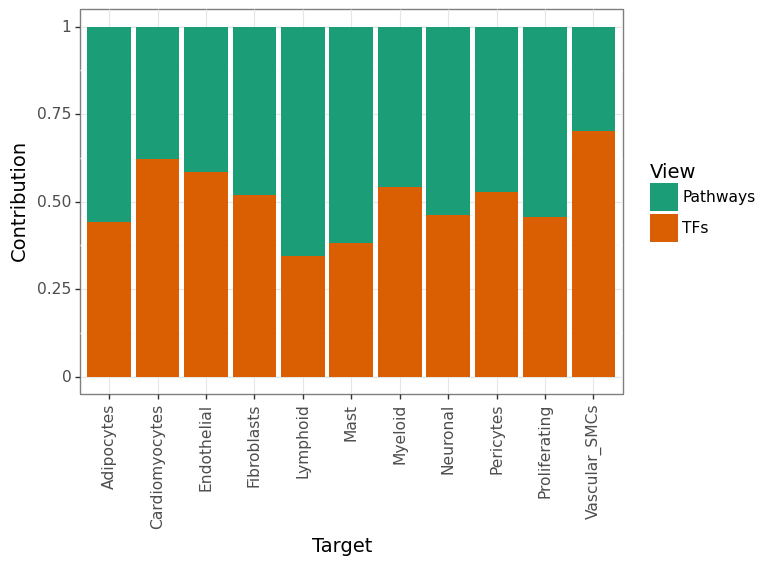

<ggplot: (8741322903444)>

In [38]:
li.pl.contributions(misty, return_fig=True)

Plot cell type x Trascription factor interactions

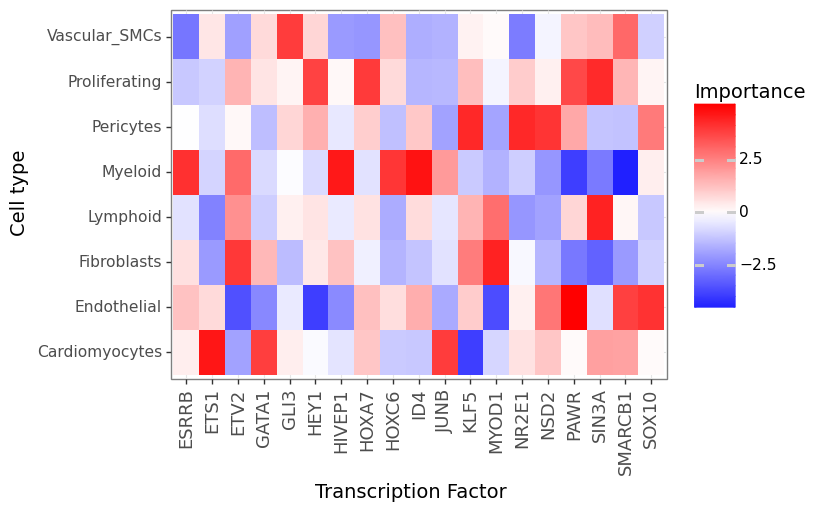

<ggplot: (8741341949055)>

In [39]:
(
    li.pl.interactions(misty, view='TFs', top_n=20) + 
    p9.labs(x='Transcription Factor', y='Cell type') +
    p9.theme_bw(base_size=14) +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=13)) +
    # change to blue-red
    p9.scale_fill_gradient2(low='blue', mid='white', high='red')
)


## Ligand-Receptor Misty

Finally, we provide a utility function that builds an object with receptors in the intra view and ligands in the para view (or in their surrounding).

For the sake of computational speed, let's identify the highly variable genes

In [40]:
sc.pp.highly_variable_genes(adata)
hvg = adata.var[adata.var['highly_variable']].index

Build LR Misty object:

In [41]:
misty = lrMistyData(adata[:, hvg], bandwidth=200, set_diag=False, cutoff=0.01, nz_threshold=0.1)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [42]:
misty(bypass_intra=True, model='linear', verbose=True)

Now learning: CSF3R: 100%|██████████| 89/89 [01:23<00:00,  1.06it/s]  


Let's now explore the top interactions between the ligands and receptors:

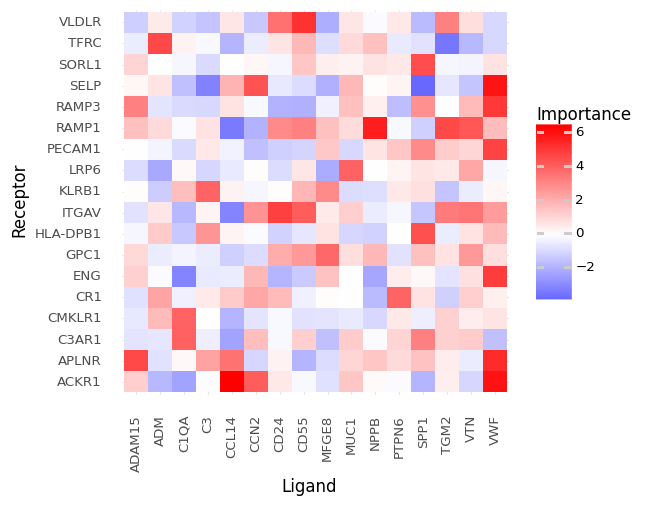

<ggplot: (8741319666914)>

In [43]:
(
    li.pl.interactions(misty, 'extra', return_fig=True, figure_size=(5, 5), top_n=25, key=abs) + 
    p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    p9.labs(y='Receptor', x='Ligand')
)

<div class="alert alert-info">

In contrast to any other other functions in LIANA, misty will infer all possible interactions between ligands and receptors - i.e. not only those that were annotated specifically as ligand-receptor interactions. 

</div>  

While this can be seen as a limitation, it can also be seen as an advantage of MISTy, as it allows us to explore potential ligand-receptor interactions that were not previously annotated!

<div class="alert alert-info">
  While MISTy provides a flexible framework for the inference of spatially-informed interactions, it only summarizes relationships between the variables on the level of the whole slide (or niche); one should thus consider  <a href="https://liana-py.readthedocs.io/en/latest/notebooks/bivariate.html"> LIANA+'s bivariate local functions</a>. These are simple spatially-informed spatially-informed metrics calculated at the spot-/cell-level. Thus, one can use them to visualize and explore the local distribution of interactions with spatial context.
</div>

### Citing MISTy:

If you use MISTy via LIANA+, please cite MISTy's original publication ([Tanevski et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02663-5))

Simiarly, consider citing any other database or method that you used in your analysis!